In [1]:
import os
import pandas as pd
import quantstats as qs
import yfinance as yf
from modules.strategy import group4_ensemble_model_signals

from zipline.api import (order, order_target, record, symbol, get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
tickers = os.listdir('./CSVs/daily/')
tickers = [x.replace('.csv', '') for x in tickers]
print("Number of assets: ", len(tickers))
print(tickers)

Number of assets:  50
['BKR', 'AAPL', 'ABT', 'ADBE', 'AEP', 'AES', 'AFL', 'ALGN', 'AMD', 'AMT', 'AOS', 'APA', 'APD', 'ARE', 'AWK', 'AXON', 'BA', 'BAC', 'BAX', 'BDX', 'BG', 'BX', 'BXP', 'CAT', 'CCI', 'CDNS', 'CE', 'CHTR', 'CMS', 'COF', 'CPB', 'CPT', 'DIS', 'EA', 'FMC', 'GOOGL', 'GS', 'IFF', 'KLAC', 'LNT', 'MMM', 'MO', 'NVDA', 'STZ', 'TECH', 'TRGP', 'VLO', 'WBD', 'WMB', 'WMT']


In [3]:
start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2022-12-31')

window = 100
capital_base = 100000

In [4]:
%%capture backtest_cell_output 

def initialize(context):
    context.i = 0

    assets = list()
    for ticker in tickers:
        assets.append(symbol(ticker))
    context.assets = assets
    context.position = 10
    
    
def handle_data(context, data):
    context.i += 1
    if context.i < window + 1:
        return

    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):

            curr_win_data = data.history(asset, ['open', 'high', 'low', 'close', 'volume'], bar_count=window, frequency="1d")
            signal = group4_ensemble_model_signals(curr_win_data)

            if signal == 1:
                order_target(asset, context.position)
            elif signal == -1: 
                order_target(asset, 0)
            else:
                pass
    


result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    bundle='snp50',
    data_frequency='daily',
    )
                        

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-29   2018-05-29
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          41.09%       7.94%
Mean Active Return         0.0%         -0.03%
CAGR﹪                     5.31%        1.16%

Sharpe                     0.45         0.29
Prob. Sharpe Ratio         83.01%       73.33%
Smart Sharpe               0.44         0.29
Sortino                    0.62         0.4
Smart Sortino              0.61         0.39
Sortino/√2                 0.44         0.28
Smart Sortino/√2           0.43         0.27
Omega                      1.05         1.05

Max Drawdown               -33.92%      -14.54%
Longest DD Days            361          484
Volatility (ann.)          22.2%        6.37%
R^2                        0.59         0.59
Calmar               

None

-0.028738590439675357





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-09-03,2022-10-14,2022-12-30,484,-14.542226,-14.357323
2,2020-02-18,2020-03-23,2020-08-21,186,-7.350663,-6.980359
3,2018-09-21,2018-12-24,2019-04-25,217,-5.731734,-5.048645
4,2020-09-03,2020-09-23,2020-11-06,65,-3.483433,-3.413941
5,2021-02-17,2021-03-04,2021-04-14,57,-2.703712,-2.577109


Average Long Exposure = 34453.38419380461
Average Short Exposure = 0.0
Average Net Leverage = 0.3181377129164018
Average Gross Leverage = 0.3181377129164018
Max Leverage = 0.5825611328264492



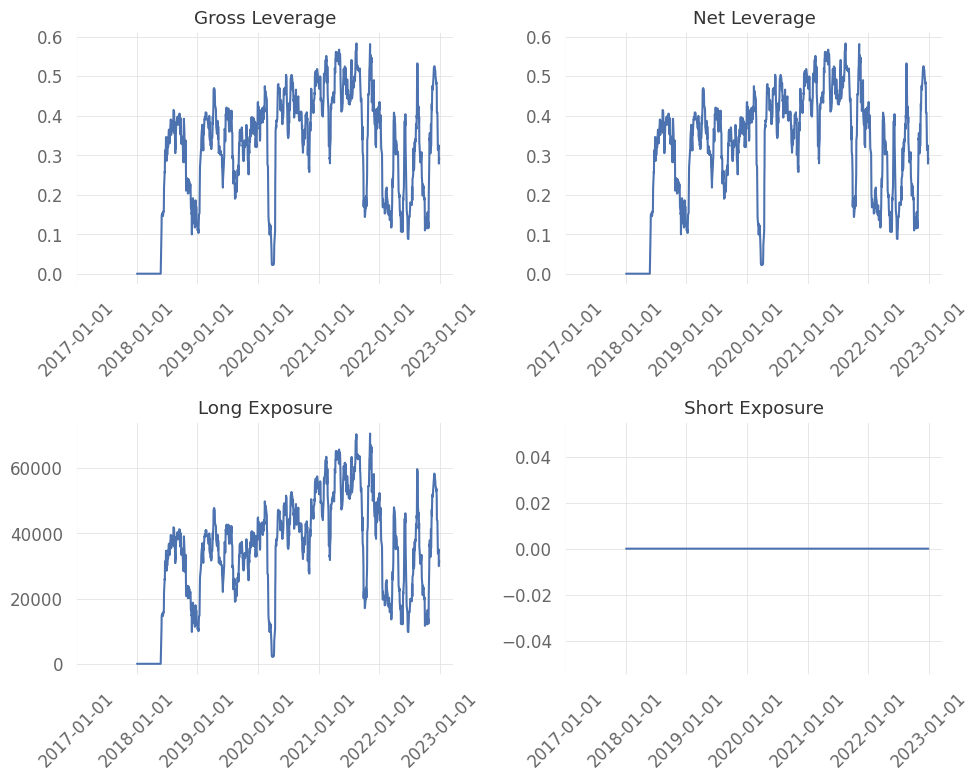

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS APA APD ARE AWK AXON BA BAC BAX BDX BG BKR BX BXP CAT CCI CDNS CE CHTR CMS COF CPB CPT DIS EA FMC GOOGL GS IFF KLAC LNT MMM MO NVDA STZ TECH TRGP VLO WBD WMB WMT


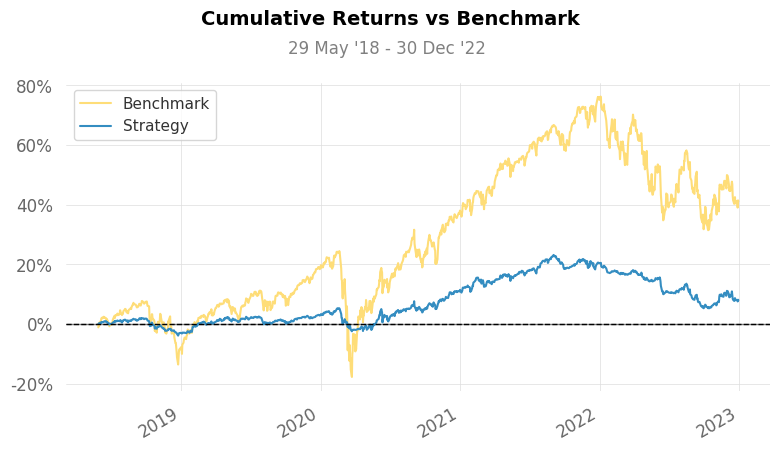

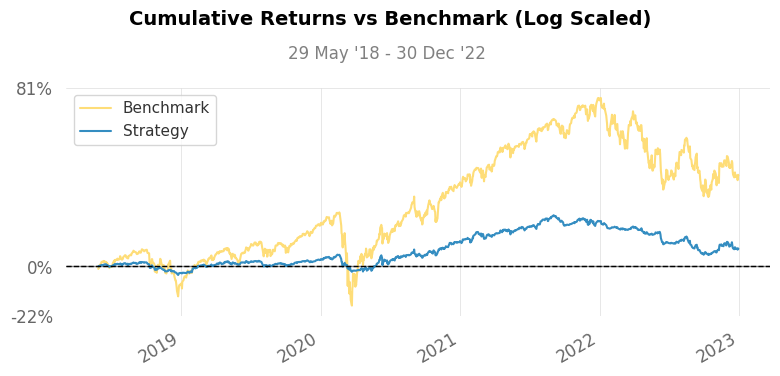

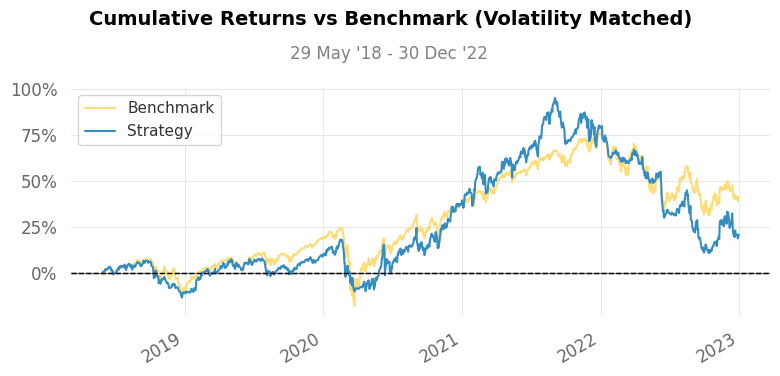

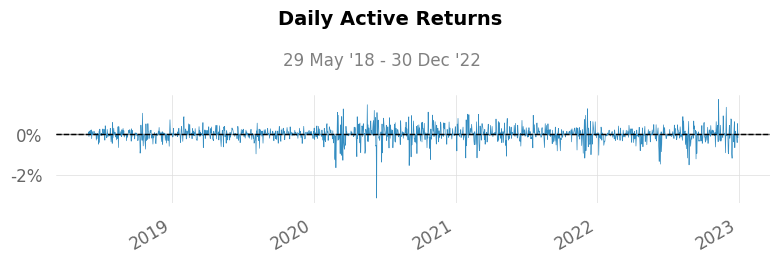

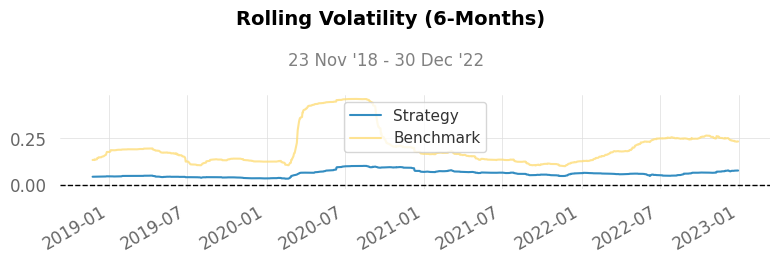

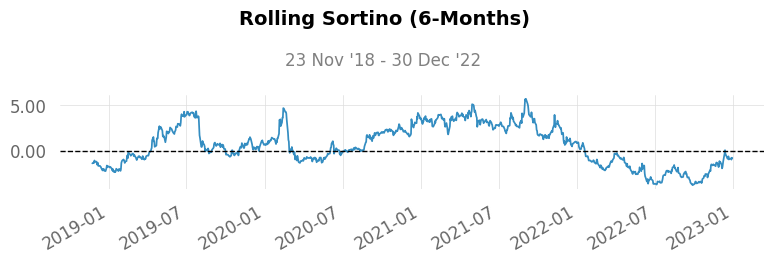

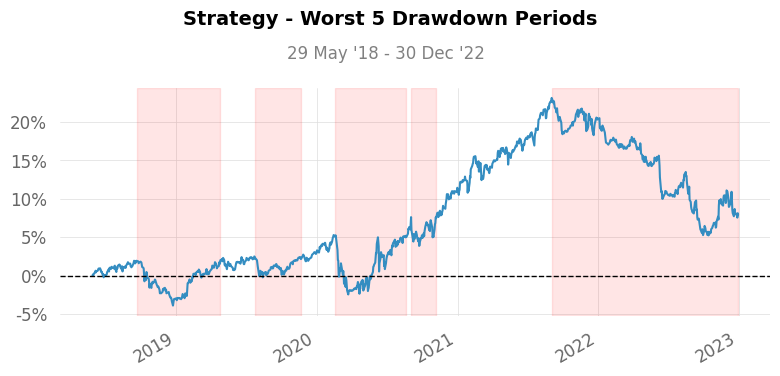

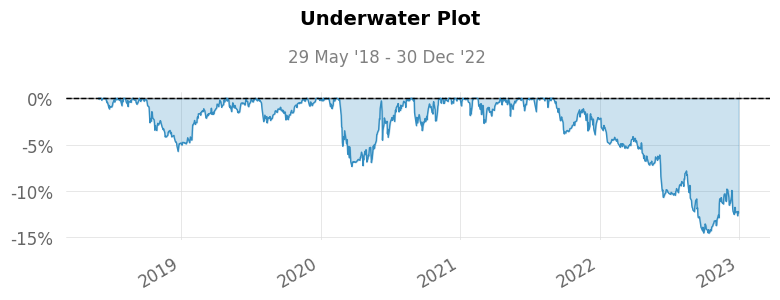

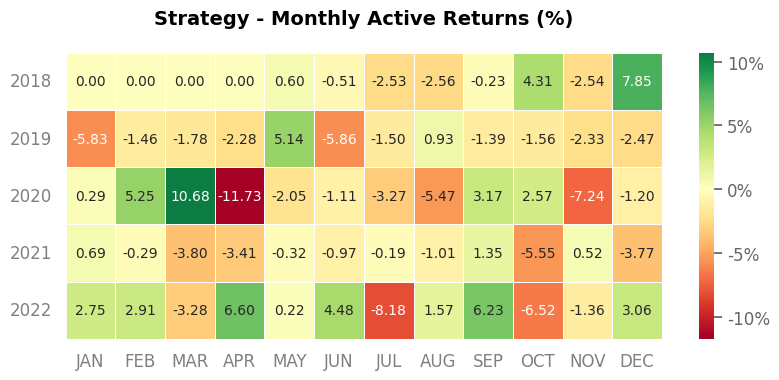

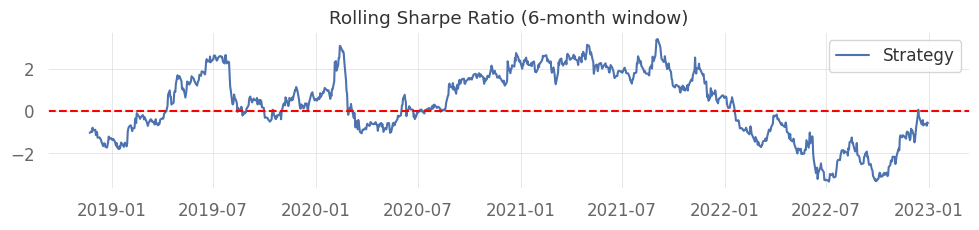

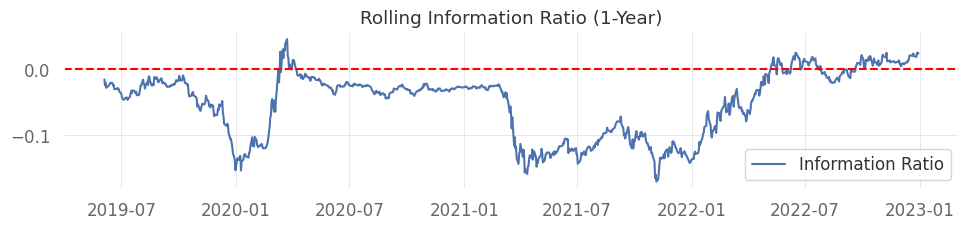

[*********************100%%**********************]  1 of 1 completed


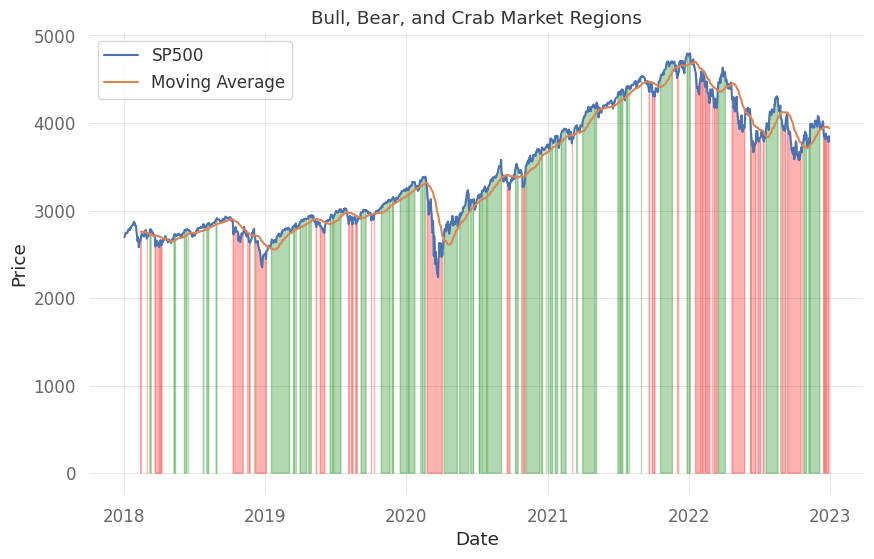

Total Trades: 2311
Daily Trades: 2
Weekly Trades: 10
Monthly Trades: 42





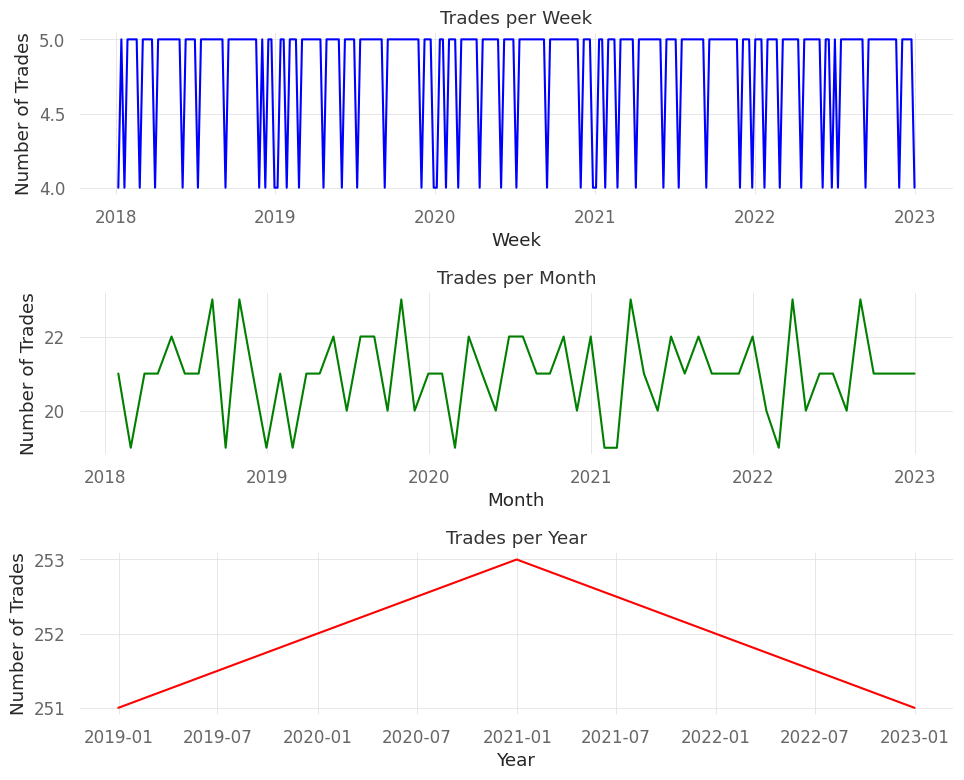

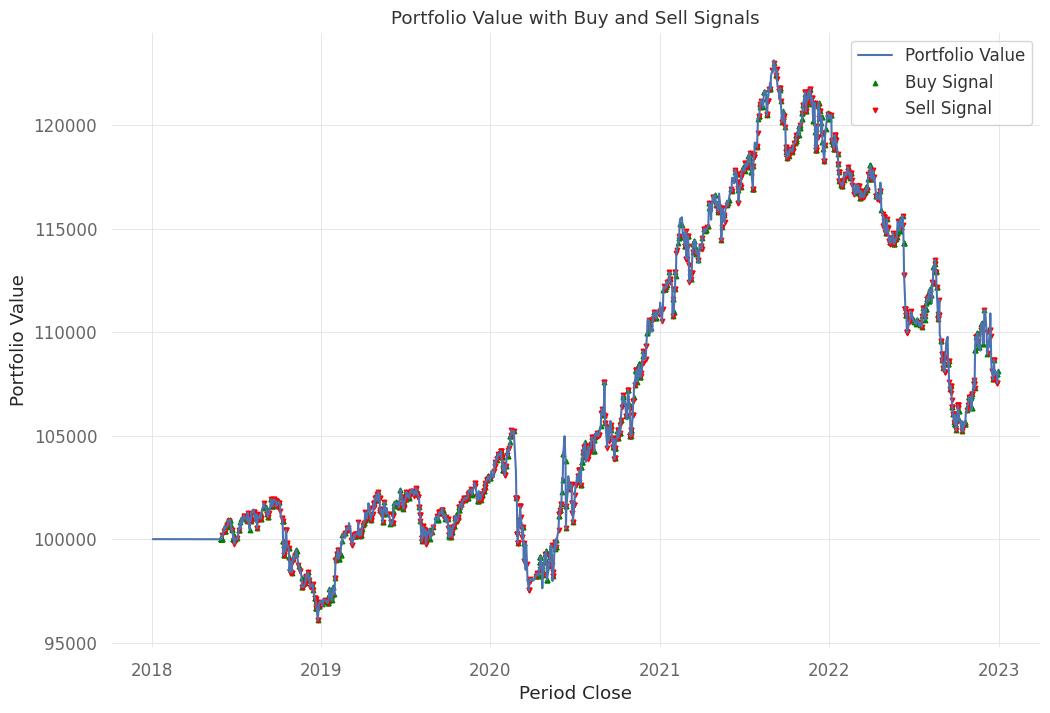

In [5]:
benchmark_returns = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')['Adj Close'].pct_change()
result.returns.index = benchmark_returns.index
result.index = benchmark_returns.index

qs.reports.full(result.returns, benchmark=benchmark_returns, df=result)

### Backtest with adaptive position allocation

In [4]:
%%capture backtest_cell_output 

def initialize(context):
    context.i = 0

    assets = list()
    for ticker in tickers:
        assets.append(symbol(ticker))
    context.assets = assets
    context.position = 10
    
    
def handle_data(context, data):
    context.i += 1
    if context.i < window + 1:
        return

    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):

            curr_win_data = data.history(asset, ['open', 'high', 'low', 'close', 'volume'], bar_count=window, frequency="1d")
            signal, stability = group4_ensemble_model_signals(curr_win_data, return_stability=True)

            # position = round((context.portfolio.cash / data.current(asset, "price"))) * stability)
            print(f'{asset}, Signal: {signal}, Stability: {stability}, Position:{round(context.position * stability)}, Available Cash: {context.portfolio.cash}')

            if signal == 1:
                order_target(asset, round(context.position*stability))
            elif signal == -1: 
                order_target(asset, 0)
            else:
                pass
    


result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    bundle='snp50',
    data_frequency='daily',
    )
                        

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-29   2018-05-29
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          41.09%       3.23%
Mean Active Return         0.0%         -0.04%
CAGR﹪                     5.31%        0.48%

Sharpe                     0.45         0.23
Prob. Sharpe Ratio         83.01%       68.45%
Smart Sharpe               0.44         0.22
Sortino                    0.62         0.3
Smart Sortino              0.61         0.3
Sortino/√2                 0.44         0.21
Smart Sortino/√2           0.43         0.21
Omega                      1.04         1.04

Max Drawdown               -33.92%      -8.11%
Longest DD Days            361          484
Volatility (ann.)          22.2%        3.31%
R^2                        0.57         0.57
Calmar                 

None

-0.02932719211072658





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-09-03,2022-09-30,2022-12-30,484,-8.106889,-7.966802
2,2020-02-20,2020-03-23,2020-08-27,190,-3.798538,-3.600305
3,2018-09-17,2018-12-24,2019-04-26,222,-2.865340,-2.514838
4,2020-09-03,2020-09-23,2020-11-06,65,-1.708900,-1.670169
5,2021-02-17,2021-03-04,2021-04-15,58,-1.437021,-1.377937


Average Long Exposure = 17028.390555202543
Average Short Exposure = 0.0
Average Net Leverage = 0.16388056846443108
Average Gross Leverage = 0.16388056846443108
Max Leverage = 0.31890848950755346



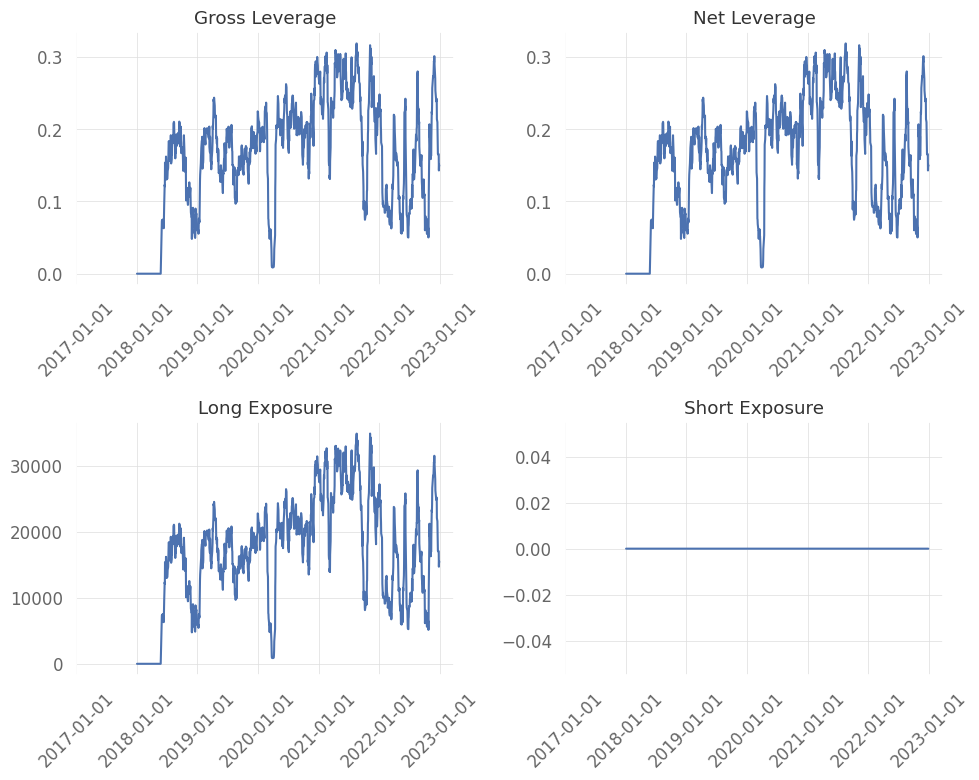

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS APA APD ARE AWK AXON BA BAC BAX BDX BG BKR BX BXP CAT CCI CDNS CE CHTR CMS COF CPB CPT DIS EA FMC GOOGL GS IFF KLAC LNT MMM MO NVDA STZ TECH TRGP VLO WBD WMB WMT


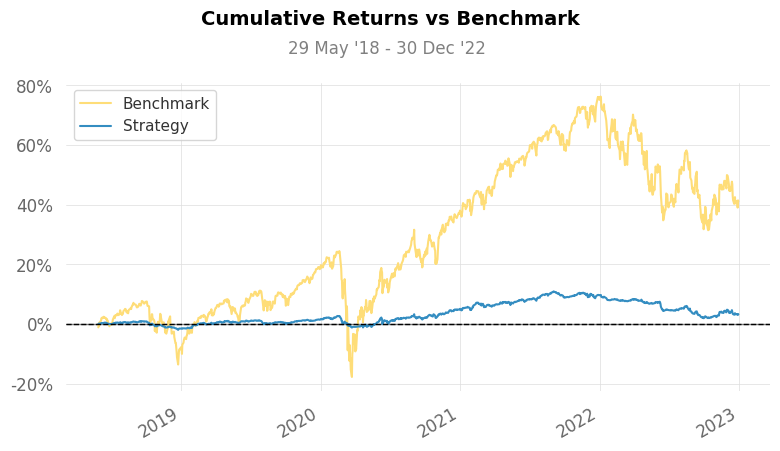

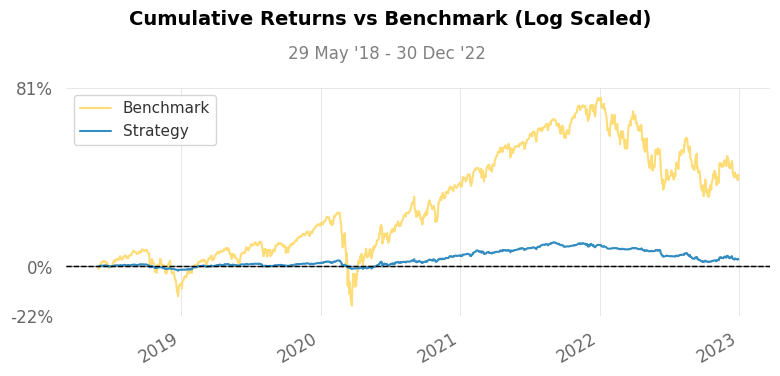

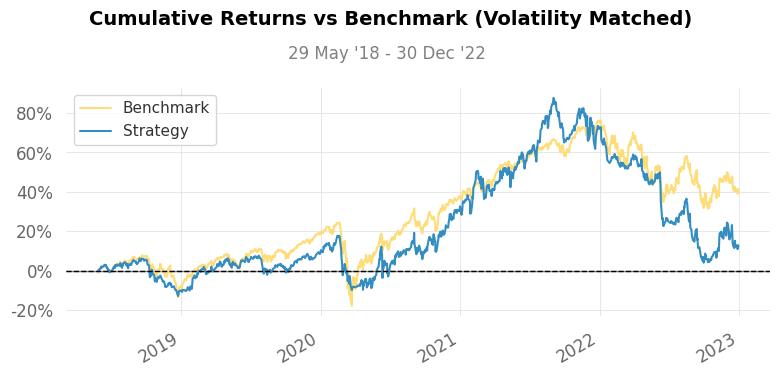

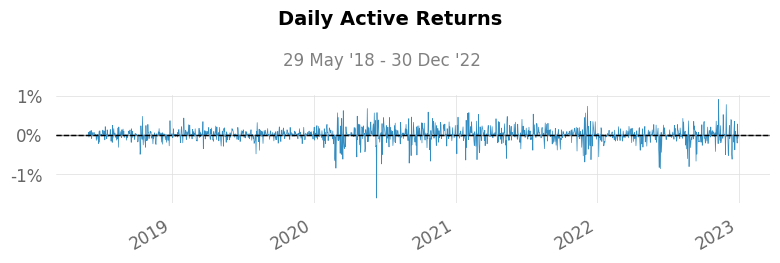

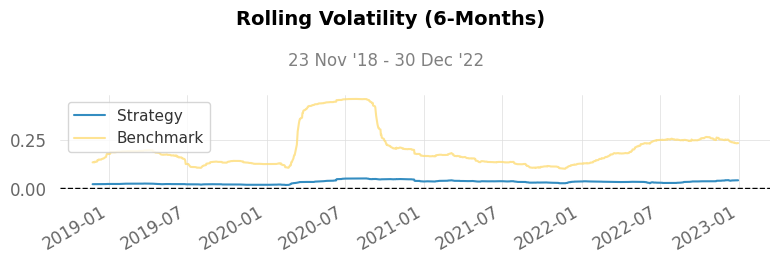

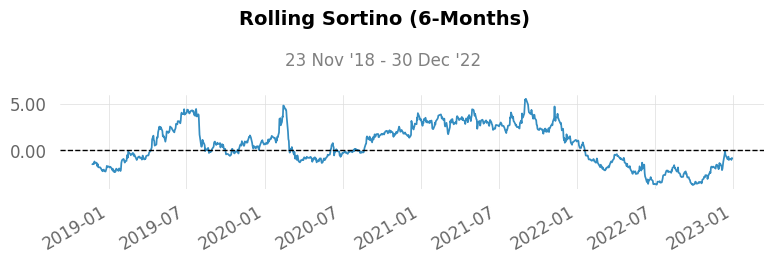

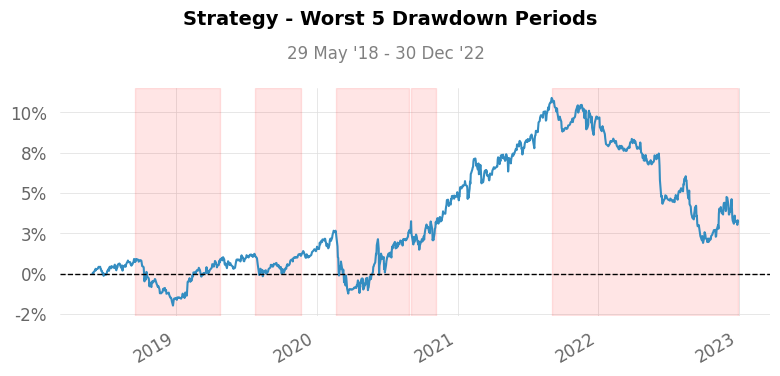

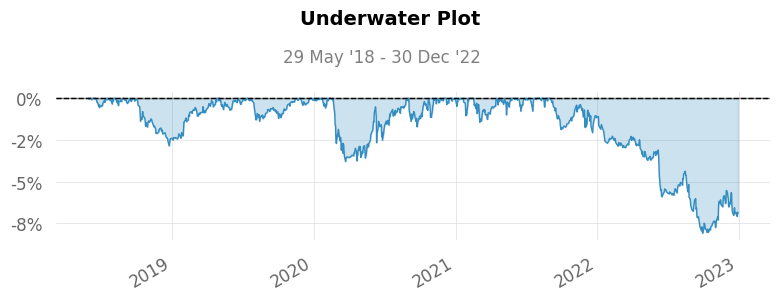

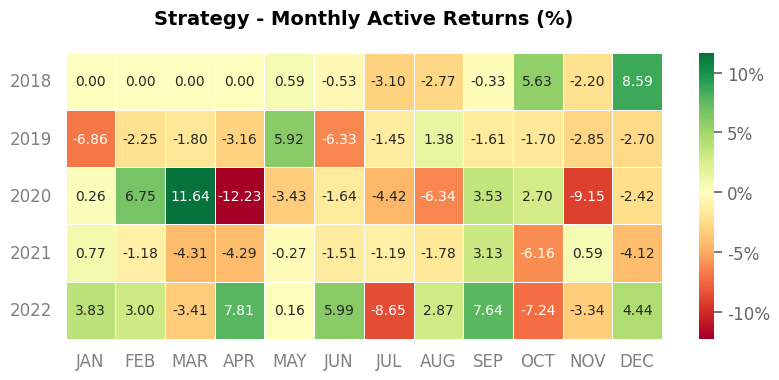

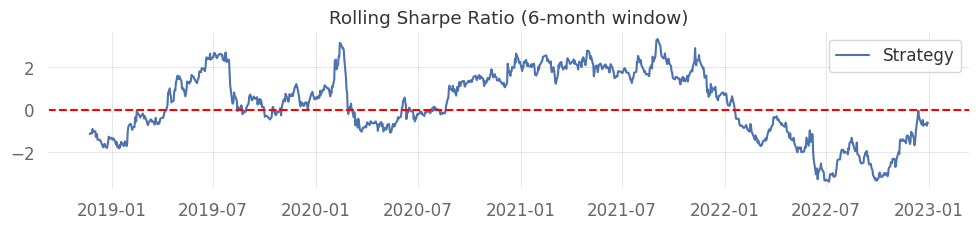

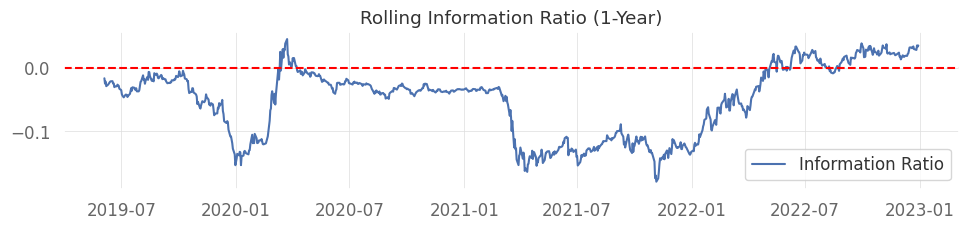

[*********************100%%**********************]  1 of 1 completed


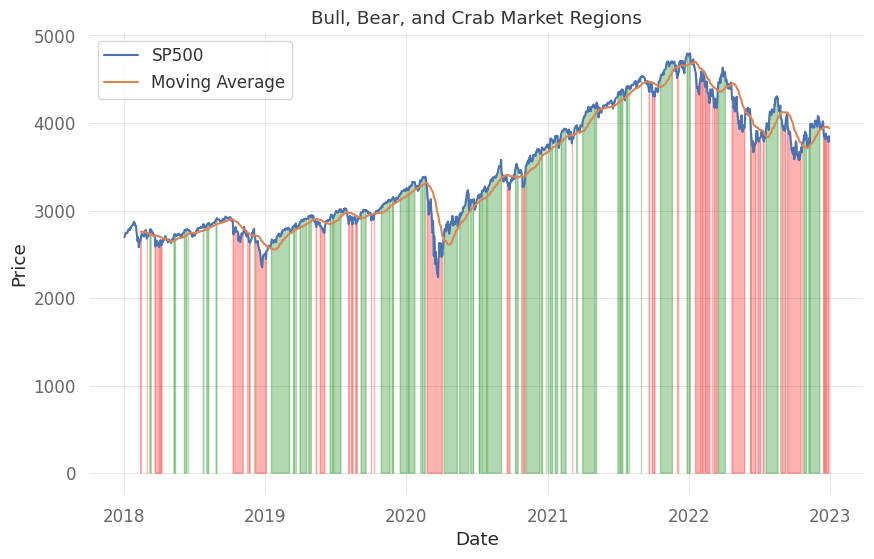

Total Trades: 7717
Daily Trades: 7
Weekly Trades: 35
Monthly Trades: 147





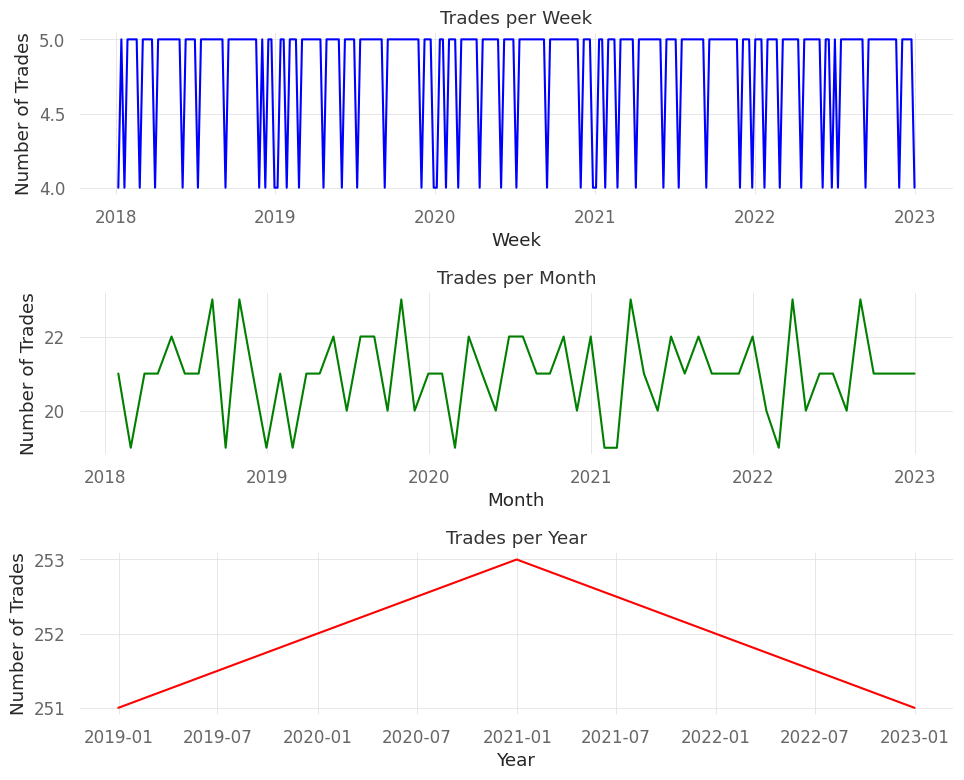

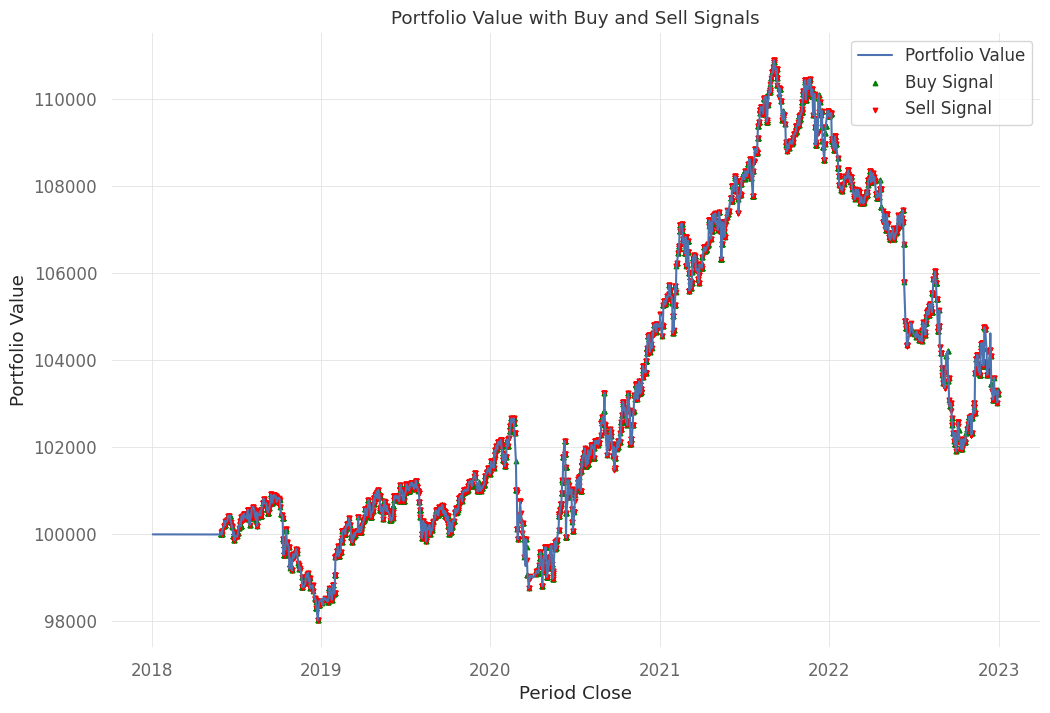

In [5]:
benchmark_returns = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')['Adj Close'].pct_change()
result.returns.index = benchmark_returns.index
result.index = benchmark_returns.index

qs.reports.full(result.returns, benchmark=benchmark_returns, df=result)